Before SMOTE: [986 190]
After SMOTE : [986 986]
Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Program Files\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:34:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

Model Evaluation on Test Set (Threshold=0.3):
Accuracy : 0.8095238095238095
Precision: 0.41509433962264153
Recall   : 0.46808510638297873
F1-score : 0.44
ROC-AUC  : 0.756826600051684

Classification Report:
              precision    recall  f1-score   support

No Attrition       0.90      0.87      0.89       247
   Attrition       0.42      0.47      0.44        47

    accuracy                           0.81       294
   macro avg       0.66      0.67      0.66       294
weighted avg       0.82      0.81      0.81       294


Confusion Matrix:
[[216  31]
 [ 25  22]]


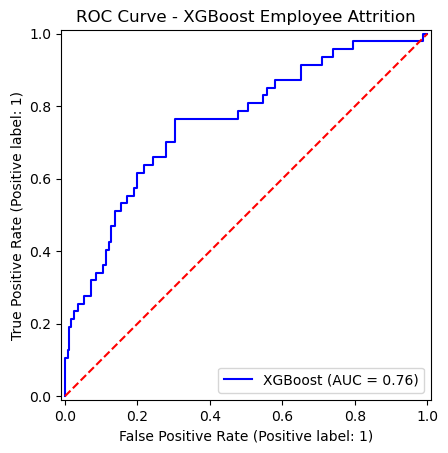

c:\Program Files\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:34:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:34:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Program Files\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:35:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.up

5-Fold CV ROC-AUC Scores: [0.98295134 0.97092755 0.96743024 0.96812595 0.97544384]
Mean ROC-AUC: 0.9729757832388664


<Figure size 800x600 with 0 Axes>

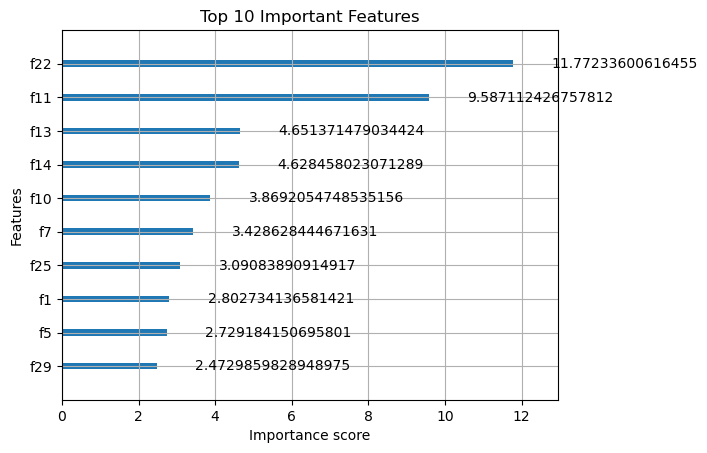

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix,
    RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

df = pd.read_csv("Employee-Attrition.csv")

df = df.drop(columns=['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber'])


df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})


df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])




X = df_encoded.drop(columns=['Attrition'])
y = df_encoded['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE :", np.bincount(y_train_res))


scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_res, y_train_res)
print("Best parameters found:", grid_search.best_params_)

xgb_best = grid_search.best_estimator_


y_proba = xgb_best.predict_proba(X_test_scaled)[:, 1]

threshold = 0.3
y_pred = (y_proba >= threshold).astype(int)

print("\nModel Evaluation on Test Set (Threshold={}):".format(threshold))
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["No Attrition", "Attrition"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba, name="XGBoost", color="blue")
plt.plot([0,1], [0,1], "r--")
plt.title("ROC Curve - XGBoost Employee Attrition")
plt.show()


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(xgb_best, X_train_res, y_train_res, cv=cv, scoring='roc_auc')
print("5-Fold CV ROC-AUC Scores:", roc_auc_scores)
print("Mean ROC-AUC:", np.mean(roc_auc_scores))


from xgboost import plot_importance

# Plot top 10 important features
plt.figure(figsize=(8,6))
plot_importance(xgb_best, max_num_features=10, importance_type='gain')
plt.title("Top 10 Important Features")
plt.show()

